<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Выводы</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

# Проект для «Викишоп» c BERT

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Обучите модель классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок.

Постройте модель со значением метрики качества *F1* не меньше 0.75. 

**Инструкция по выполнению проекта**

1. Загрузите и подготовьте данные.
2. Обучите разные модели. 
3. Сделайте выводы.

Для выполнения проекта применять *BERT* необязательно, но вы можете попробовать.

**Описание данных**

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

In [1]:
pip install -q transformers

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install -q torch

Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install -q lightgbm

Note: you may need to restart the kernel to use updated packages.


In [4]:
!{sys.executable} -m -q pip install spacy
!{sys.executable} -m -q spacy download en

/bin/bash: {sys.executable}: command not found
/bin/bash: {sys.executable}: command not found


In [5]:
import sys

import numpy as np
import pandas as pd
import torch
from tqdm import notebook

import lightgbm as lgb

import os
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, f1_score, ConfusionMatrixDisplay, confusion_matrix

import re
import nltk
from nltk.corpus import stopwords 

from sklearn.pipeline import Pipeline

from sklearn.tree import DecisionTreeClassifier
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

from nltk.tokenize import word_tokenize 
from nltk.stem import WordNetLemmatizer 
import spacy

from sklearn.feature_extraction.text import TfidfVectorizer

import transformers
from transformers import AutoTokenizer
from transformers import BertModel, BertConfig

In [6]:
R_STATE = 12345

## Подготовка

### Посмотрим на данные

In [7]:
pth = '/datasets/toxic_comments.csv'
pth2 = 'toxic_comments.csv'

if os.path.exists(pth):
    data = pd.read_csv(pth)
elif os.path.exists(pth2): 
    data = pd.read_csv(pth2)
else:
    print('Ошибка в считывании данных из источника {}'.format(pth))

In [8]:
data_start = data.copy()

In [9]:
data.sample(10)

,Unnamed: 0,text,toxic
147958,148114,Georgia Georgia's area is 2000 sq. km-s here.W...,0
52882,52939,"""\nWhether a particular document is a """"reliab...",0
78232,78308,Name of the Father \n\nYou commented on the Na...,0
4208,4208,Cambridge meetup 14 November\n\nAnother Cambri...,0
135717,135855,When is honestny not considered constructive? ...,0
40678,40728,"""Welcome\n\nHello and welcome to Wikipedia! W...",0
138594,138745,"""\nWow, thanks, ! That happened much faster th...",0
47032,47087,"De Neville \n\nHi Ealdgyth, sorry, I didn't kn...",0
57169,57230,"""\n\nCentral Atlas Tamazight\nPlease make sure...",0
138091,138238,I don't think that this is a view necessarily ...,0


In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159292 entries, 0 to 159291
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Unnamed: 0  159292 non-null  int64 
 1   text        159292 non-null  object
 2   toxic       159292 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 3.6+ MB


In [11]:
data.duplicated().sum()

0

In [12]:
data.isnull().sum()

Unnamed: 0    0
text          0
toxic         0
dtype: int64

In [13]:
data = data.drop('Unnamed: 0', axis = 1)

In [14]:
data['toxic'].unique()

array([0, 1])

In [15]:
data['toxic'].describe()

count    159292.000000
mean          0.101612
std           0.302139
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           1.000000
Name: toxic, dtype: float64

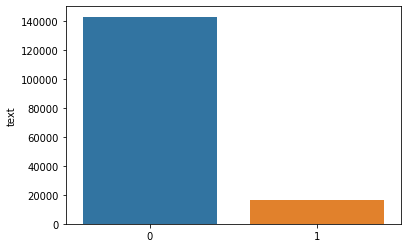

In [16]:
sns.barplot(x=data['toxic'].unique(), y=data.groupby('toxic').count()['text']) 
print()

Существует сильный дисбаланс классов с перевесом в сторону 0. 

In [17]:
data.head()

,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0


### Отчистка и лемматизация

In [19]:
stop_words = set(stopwords.words('english'))

In [20]:
nlp = spacy.load("en_core_web_sm", disable=['parser', 'ner'])
def clear_and_lem_sp (text):
    text = re.sub(r'[^a-zA-Z]', ' ',text)
    text = text.lower()
    text = text.split()
    text = ' '.join(text) 
    lemm_text = nlp(text)
    lemm_text = " ".join([token.lemma_ for token in lemm_text])
    return lemm_text

In [21]:
%%time 
data['lemm_text_spacy'] = data['text'].apply(lambda x: clear_and_lem_sp(x))#.replace("\n", "", 1))

In [22]:
data.head()

,text,toxic,lemm_text_spacy
0,Explanation\nWhy the edits made under my usern...,0,explanation why the edit make under my usernam...
1,D'aww! He matches this background colour I'm s...,0,d aww he match this background colour I m seem...
2,"Hey man, I'm really not trying to edit war. It...",0,hey man I m really not try to edit war it s ju...
3,"""\nMore\nI can't make any real suggestions on ...",0,more I can t make any real suggestion on impro...
4,"You, sir, are my hero. Any chance you remember...",0,you sir be my hero any chance you remember wha...


<font color='blue'><b>Комментарий ревьюера 2: </b></font> ✔️\
<font color='green'> Отлично! Теперь видно, что слова в начальных формах.</font>

In [23]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /home/jovyan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [24]:
lemmatizer = WordNetLemmatizer()

In [25]:
def clear_and_lem_wnl (text):
    text = re.sub(r'[^a-zA-Z]', ' ',text)
    text = text.lower()
    text = text.split()
    text = ' '.join(text) 
    token = nltk.word_tokenize(text)
    #text = [word for word in token if word not in stop_words]
    lemm_list = lemmatizer.lemmatize(text)
    lemm_text = "".join(lemm_list)
    return lemm_text

In [26]:
%%time 
data['lemm_text_word'] = data['text'].apply(lambda x: clear_and_lem_wnl(x).replace("\n", "", 1))

CPU times: user 1.49 s, sys: 46.4 ms, total: 1.54 s
Wall time: 1.54 s


In [27]:
data.head()

,text,toxic,lemm_text_spacy,lemm_text_word
0,Explanation\nWhy the edits made under my usern...,0,explanation why the edit make under my usernam...,explanation why the edits made under my userna...
1,D'aww! He matches this background colour I'm s...,0,d aww he match this background colour I m seem...,d aww he matches this background colour i m se...
2,"Hey man, I'm really not trying to edit war. It...",0,hey man I m really not try to edit war it s ju...,hey man i m really not trying to edit war it s...
3,"""\nMore\nI can't make any real suggestions on ...",0,more I can t make any real suggestion on impro...,more i can t make any real suggestions on impr...
4,"You, sir, are my hero. Any chance you remember...",0,you sir be my hero any chance you remember wha...,you sir are my hero any chance you remember wh...


Кажется, что вариант `spacy` лучше, оставим его. 

In [27]:
data = data.drop(['text','lemm_text_word'], axis = 1).rename(columns={'lemm_text_spacy':'text'})

In [28]:
data.head()

**Вывод: перед обучением мы имеем размеченный и лемматизированный текст длиной порядка 160 тыс. строк (в матричном понимании, а не литературном. сами тексты различного размера)** 

## Обучение

In [29]:
features = data.drop(['toxic'], axis = 1)
target = data['toxic']

In [30]:
features_train, features_test, target_train, target_test = train_test_split(features, target, test_size = 0.2, stratify = target, random_state = R_STATE)
print('Train data shape:', features_train.shape, target_train.shape)
print('Test data shape:', features_test.shape, target_test.shape)

In [31]:
def training(clf, params):
    pipeline = Pipeline([
        ('tfidf', TfidfVectorizer(stop_words=stop_words)),
        ('model', clf)])
    model = GridSearchCV(pipeline, cv = 5, n_jobs = -1, param_grid = params ,scoring = 'f1', verbose = False)
    model.fit(features_train['text'], target_train)
    print('Лучший результат:', model.best_score_)
    print('Лучшие параметры:', model.best_params_)
    return model.best_estimator_

In [32]:
%%time
warnings.filterwarnings("ignore")
LR_params = {'model__C':[0.1, 1.0, 10.0], 'model__penalty':['l2','elasticnet']}
LR_clf = training(LogisticRegression(random_state = R_STATE, class_weight = 'balanced'), LR_params)

In [33]:
%%time
DTC_params = {'model__criterion':['gini'],
              'model__max_depth':[2,6,8],
              'model__min_samples_split':[5]}

DTC_clf = training(DecisionTreeClassifier(random_state = R_STATE, class_weight = 'balanced'), DTC_params )

In [34]:
%%time
RFC_params = {'model__n_estimators':[50, 100],
              'model__criterion':['gini'],
              'model__max_depth':[2,4],
              'model__min_samples_split':[5]}

RFC_clf = training(RandomForestClassifier(random_state = R_STATE, class_weight = 'balanced'), RFC_params)

In [35]:
%%time
LGB_params = {
    'model__n_estimators': np.arange(50, 120, step=50),
    'model__max_depth': list(np.arange(2, 7, step=3)),
    'model__class_weight': ['balanced']
    }

LGB_clf = training(lgb.LGBMClassifier(random_state = R_STATE, verbose=-1, class_weight = 'balanced'), LGB_params)

In [36]:
%%time
D_params = {
    'model__strategy': ['stratified']
    }

D_clf = training(DummyClassifier(random_state = R_STATE), D_params)

Проверим модель LogisticRegression на тесте. 

In [37]:
features_test = LR_clf[0].transform(features_test['text'])

In [38]:
predictions_LR = LR_clf[1].predict(features_test)

In [39]:
f1_test = f1_score(target_test, predictions_LR)
print('f1 для LR модели на тесте :', f1_test) 
print('accuracy для LR модели на тесте :', accuracy_score(target_test, predictions_LR))

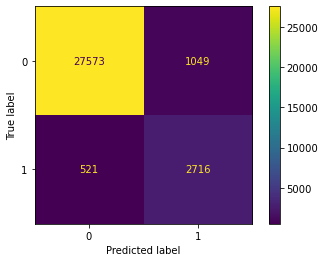

In [40]:
ConfusionMatrixDisplay(confusion_matrix = confusion_matrix(target_test, predictions_LR)).plot()
plt.show()

Мы довольно часто (в 15% случаев) не угадываем токсичный комментарий и довольно редко (в 4% случаев) называем комментарий токсичным, когда он таковым не является. 

## BERT

Отберем случайные 10% данных, т.к. дообучение предобученной модели BERT требует большое количество времени. 

In [41]:
data_bert = data.sample(16000)
data_bert.reset_index(drop = True, inplace= True)

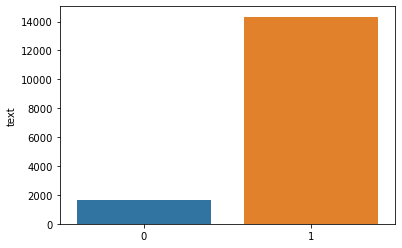

In [42]:
sns.barplot(x=data_bert['toxic'].unique(), y=data_bert.groupby('toxic').count()['text']) 
print()

Ограничим длину текста 500 словами, т.к. максимальная размерность для нашей модели это 512 токенов. 

In [43]:
for i in range(len(data_bert)):
    data_bert['text'][i] = data_bert['text'][i][0:500]

### Загрузка предобученной модели/токенизатора 

In [44]:
tokenizer = AutoTokenizer.from_pretrained('bert-base-cased', truncation=True, max_length=512)

# Initializing a BERT bert-base-uncased style configuration
configuration = BertConfig()

# Initializing a model from the bert-base-uncased style configuration
model = BertModel(configuration)

# Accessing the model configuration
configuration = model.config

<font color='blue'><b>Комментарий ревьюера : </b></font> ✔️\
<font color='green'> Для этой задачи существуют специальные модели, например 'unitary/toxic-bert'</font>

In [45]:
tokenized = data_bert['text'].apply(
    lambda x: tokenizer.encode(x, add_special_tokens=True))

max_len = 0
for i in tokenized.values:
    if len(i) > max_len:
        max_len = len(i)

padded = np.array([i + [0]*(max_len - len(i)) for i in tokenized.values])

attention_mask = np.where(padded != 0, 1, 0)

In [46]:
%%time
batch_size = 100
embeddings = []
for i in notebook.tqdm(range(padded.shape[0] // batch_size)):
        batch = torch.LongTensor(padded[batch_size*i:batch_size*(i+1)]) 
        attention_mask_batch = torch.LongTensor(attention_mask[batch_size*i:batch_size*(i+1)])
        
        with torch.no_grad():
            batch_embeddings = model(batch, attention_mask=attention_mask_batch)
        
        embeddings.append(batch_embeddings[0][:,0,:].numpy())

In [47]:
features_bert = np.concatenate(embeddings)
target_bert = data_bert['toxic']
features_bert_train, features_bert_test, target_bert_train, target_bert_test = train_test_split(features_bert, target_bert, test_size = 0.2, stratify = target_bert, random_state = R_STATE)

In [51]:
%%time
LR_params = {'C':[0.1, 1.0, 10.0], 'penalty':['l2','elasticnet']}
model = GridSearchCV(LogisticRegression(random_state = R_STATE,  class_weight = 'balanced'), cv = 5, n_jobs = -1, param_grid = LR_params ,scoring = 'f1', verbose = False)
model.fit(features_bert_train, target_bert_train)
print('Лучший результат:', model.best_score_)
print('Лучшие параметры:', model.best_params_)
BERT_model = model.best_estimator_

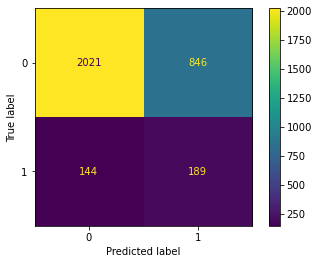

In [52]:
predictions_BERT_LR = BERT_model.predict(features_bert_test)
f1_test = f1_score(target_bert_test, predictions_BERT_LR)
print('f1 для LR модели на тесте с использованием BERT :', f1_test) 
print('accuracy для LR модели на тесте :', accuracy_score(target_bert_test, predictions_BERT_LR))
ConfusionMatrixDisplay(confusion_matrix = confusion_matrix(target_bert_test, predictions_BERT_LR)).plot()
plt.show()

## Выводы

В этой работе нам предстояло научить модели классифицировать размеченые тексты и  мы испробовали 2 подхода создания фич для классфикации. Первый подход заключался в создании фич в виде индексов `TF-IDF`, в этом подходе мы обучили модели `RFC`, `LR`,`DTC` , `LightGBM` и наилучшее `f1 score` показала модешь LogisticRegression. Она была выбрана для теста и на тесте показала значение `f1 score` равное 0.78.
Второй подход в создании фич заключался в использовании предобученной модели BERT, которую мы дообучали уже на наших данных. Для модели BERT были использованы только 10% данных. Логистическая регрессия на модели BERT показала довольно низкое значение `f1 score`. Таким образом наилучший результат мы смогли достигнуть путем использования моделей основанных на фичах TF-IDF.
Но стоит заметить, что модель BERT имеет большой потенциал, т.к. мы использовали малую часть имеющихся данных для обучения модели. 